# Computational Methods in Economics Final Project

#### GitHub Repository:
https://github.com/coquetm/CMiE-2017-Manuel-Coquet

In [60]:
using JuMP, Ipopt, Plots, DataFrames, GLPKMathProgInterface, FileIO
gr()

Plots.GRBackend()

## Policy Appications of Power Systems Modelling

- In this project, I start by building Power Flow model for a small network and comparing the computational efficiency of Newton's method and the optimizing package JuMP in Julia.


- Afterwards, I expand the Power Flow model into an Optimal Power Flow to optimize the operation and planning of a power grid based on minimizing generation costs, and to determine Locational Marginal Prices that generators and load consumers face.


- In addition, I use the Optimal Power Flow model to examine an example of Market Power and the incompatibility of incentives between profit-maximizing for a firm and optimizing the welfare of society.


- Finally, I replicate a Mixed Integer Linear (MILP) approach to solving the transmission expansion planning problem from the paper Transmission Expansion Planning: A Mixed-Integer LP Approach (2003) by Natalia Alguacil, Alexis L. Motto and Antonio J. Conejo.


## 1. AC Power Flow analysis
An alternating current power-flow model is a model used in electrical engineering to analyze power grids. It provides a nonlinear system which describes the energy flow through each transmission line. The goal of a power-flow study is to obtain complete voltages angle and magnitude information for each bus in a power system for specified load and generator real power and voltage conditions.  

Once this information is known, real and reactive power flow on each branch as well as generator reactive power output can be analytically determined. Power-flow or load-flow studies are important for planning future expansion of power systems as well as in determining the best operation of existing systems. 

### Problem description (example)
- Consider a network with 5 buses that forms a cycle (i.e., the lines are (1,2), (2,3), (3,4),(4,5) and (5,1)).
- Assume that Bus 1 is a slack, Bus 2 is PV (generator) and Buses 3-5 are PQ (loads).
- Assume that the resistance and reactance of each line are both equal to 1.

Repeat the following lines 1-3 several times (say 100 times):
- 1: Generate a random vector V such that all voltage magnitudes are somehow close to 1 and all voltage angles are close to 0, and that the phase at the slack bus is zero.
- 2: Based on the random vector of voltages V, compute the loads at the PQ buses, the P and |V| values at the PV buses, and |V| at the slack bus. (constraints/input data needed to run the model)
- 3: Use the measurement data to solve the power flow problem in two ways: (1) Newton's Mehtod, (2) JuMP 
- 4: Declare a success if the obtained solution matches the original random state V. Compute how many times each of the above two methods was successful for different values of voltage angles (sensitivity analysis).

#### NOTE: The problem does not always have a solution, especially at large angles

### Mathematical Formulation
The Power flow problem requires us to determine voltages angle and magnitude information for each bus in a power system for specified load and generator real power and voltage conditions:
- For generator buses (also called PV) - we are given Pᵢ & |Vᵢ| -> need to solve for θᵢ & Qᵢ
- For load buses (also called PQ) - we are given Pᵢ & Qᵢ -> need to solve for θᵢ & |Vᵢ|
- For the slack bus (used to balance other buses) - we are given |Vᵢ| & θᵢ -> need to solve for Pᵢ & Qᵢ

Therefore our problem can be stated as:
- Known parameters: V₁, θ₁, P₂, V₂, P₃, Q₃, P₄, Q₄, P₅, Q₅
- List of unknowns: P₁, Q₁, Q₂, θ₂, V₃, θ₃, V₄, θ₄, V₅, θ₅
- Need to write equations P₂, P₃, Q₃, P₄, Q₄, P₅, Q₅

Where:
- Pᵢ = ∑|Vᵢ||Vⱼ|[Gᵢⱼ cos(θᵢⱼ) + Bᵢⱼ sin(θᵢⱼ)] 
- Qᵢ = ∑|Vᵢ||Vⱼ|[Gᵢⱼ sin(θᵢⱼ) - Bᵢⱼ cos(θᵢⱼ)]

And:
- θᵢⱼ = θᵢ - θⱼ
- Gᵢⱼ = Real(Yᵢⱼ) # admittance matrix
- Bᵢⱼ = Imaginary(Yᵢⱼ)
- Yᵢⱼ is the inverse of the impedance matrix which depends on the resistance and reactance of power lines

I will use the equations in terms of vector x to avoid confusion
x = [θ₂ θ₃ θ₄ θ₅ V₃ V₄ V₅]

## Newton's Method

We will apply a multivariable Newton's method to solve the Non-linear system of power equations according to the following algorithm:

x = [θ₂, θ₃, θ₄, θ₅, V₃, V₄, V₅]

fx = [P₂(x)-P0₂ , P₃(x)-P0₃ , P₄(x)-P0₄ , P₅(x)-P0₅ , Q₃(x)-Q0₃ , Q₄(x)-Q0₄ , Q₅(x)-Q0₅]

J = δfxᵢ / δxⱼ

while ||fx(xⁿ)|| < ϵ

    xⁿ⁺¹ = xⁿ - J(xⁿ)⁻¹f(xⁿ)
    xⁿ = xⁿ⁺¹
    
end

### Constructing the Admittance Matrix

In [2]:
# Since we are not changing resistance or reactance, the admittance matrix will always be constant

Zij = zeros(5,5)
Zij = complex(Zij)
Zij[1,2] = 1+1im; Zij[2,1] = 1+1im;
Zij[2,3] = 1+1im; Zij[3,2] = 1+1im;
Zij[3,4] = 1+1im; Zij[4,3] = 1+1im;
Zij[4,5] = 1+1im; Zij[5,4] = 1+1im;
Zij[5,1] = 1+1im; Zij[1,5] = 1+1im;
Y = zeros(5,5);
Y = complex(Y)
for i=1:5, j=1:5
    if i != j
        if Zij[i,j] != 0
            Y[i,j] = -Zij[i,j]^-1;
        else
            Y[i,j] = 0;
        end
    end
end
for i = 1:5
    Y[i,i] = -sum(Y[i,:]);
end
Y

5×5 Array{Complex{Float64},2}:
  1.0-1.0im  -0.5+0.5im   0.0+0.0im   0.0+0.0im  -0.5+0.5im
 -0.5+0.5im   1.0-1.0im  -0.5+0.5im   0.0+0.0im   0.0+0.0im
  0.0+0.0im  -0.5+0.5im   1.0-1.0im  -0.5+0.5im   0.0+0.0im
  0.0+0.0im   0.0+0.0im  -0.5+0.5im   1.0-1.0im  -0.5+0.5im
 -0.5+0.5im   0.0+0.0im   0.0+0.0im  -0.5+0.5im   1.0-1.0im

### Defining a function to evaluate fx (active and reactive power)

In [3]:
function feval(Y, V; f0 = zeros(7))

function f(x::Vector)
fx = zeros(7)
θ₁ = 0; #slack reference bus
fx[1] = V[2]*V[1]*(real(Y[2,1])*cos(x[1]-θ₁)+imag(Y[2,1])*sin(x[1]-θ₁))+ V[2]*V[2]*real(Y[2,2])+
        V[2]*x[5]*(real(Y[2,3])*cos(x[1]-x[2])+imag(Y[2,3])*sin(x[1]-x[2])) - f0[1]
fx[2] = x[5]*V[2]*(real(Y[3,2])*cos(x[2]-x[1])+imag(Y[3,2])*sin(x[2]-x[1]))+ x[5]*x[5]*real(Y[3,3])+
        x[5]*x[6]*(real(Y[3,4])*cos(x[2]-x[3])+imag(Y[3,4])*sin(x[2]-x[3])) - f0[2]
fx[3] = x[6]*x[5]*(real(Y[4,3])*cos(x[3]-x[2])+imag(Y[4,3])*sin(x[3]-x[2]))+ x[6]*x[6]*real(Y[4,4])+
        x[6]*x[7]*(real(Y[4,5])*cos(x[3]-x[4])+imag(Y[4,5])*sin(x[3]-x[4])) - f0[3]
fx[4] = x[7]*x[6]*(real(Y[5,4])*cos(x[4]-x[3])+imag(Y[5,4])*sin(x[4]-x[3]))+ x[7]*x[7]*real(Y[5,5])+
        x[7]*V[1]*(real(Y[5,1])*cos(x[4]-θ₁)+imag(Y[5,4])*sin(x[4]-θ₁)) - f0[4]
fx[5] = x[5]*V[2]*(real(Y[3,2])*sin(x[2]-x[1])-imag(Y[3,2])*cos(x[2]-x[1])) -x[5]*x[5]*imag(Y[3,3])+
        x[5]*x[6]*(real(Y[3,4])*sin(x[2]-x[3])-imag(Y[3,4])*cos(x[2]-x[3])) - f0[5]
fx[6] = x[6]*x[5]*(real(Y[4,3])*sin(x[3]-x[2])-imag(Y[4,3])*cos(x[3]-x[2]))-x[6]*x[6]*imag(Y[4,4])+
        x[6]*x[7]*(real(Y[4,5])*sin(x[3]-x[4])-imag(Y[4,5])*cos(x[3]-x[4])) - f0[6]
fx[7] = x[7]*x[6]*(real(Y[5,4])*sin(x[4]-x[3])-imag(Y[5,4])*cos(x[4]-x[3]))-x[7]*x[7]*imag(Y[5,5])+
        x[7]*V[1]*(real(Y[5,1])*sin(x[4]-θ₁)-imag(Y[5,1])*cos(x[4]-θ₁)) - f0[7]
return fx
end
    
end

### Defining a function to evaluate Jacobian

#### I did the analytical Jacobian - tried to use autodiff but i couldn't make it work

In [4]:
function Jeval(Y, V)

function J(x::Vector)
θ₁ = 0 #slack reference bus
df1x1 = V[2]*V[1]*(-real(Y[2,1])*sin(x[1]-θ₁)+imag(Y[2,1])*cos(x[1]-θ₁))+
            V[2]*x[5]*(-real(Y[2,3])*sin(x[1]-x[2])+imag(Y[2,3])*cos(x[1]-x[2]))
df1x2 = V[2]*x[5]*(real(Y[2,3])*sin(x[1]-x[2])-imag(Y[2,3])*cos(x[1]-x[2]))
df1x3 = 0
df1x4 = 0
df1x5 = V[2]*(real(Y[2,3])*cos(x[1]-x[2])+imag(Y[2,3])*sin(x[1]-x[2]))
df1x6 = 0
df1x7 = 0
df2x1 = x[5]*V[2]*(real(Y[3,2])*sin(x[2]-x[1])-imag(Y[3,2])*cos(x[2]-x[1]))
df2x2 = x[5]*V[2]*(-real(Y[3,2])*sin(x[2]-x[1])+imag(Y[3,2])*cos(x[2]-x[1]))+
            x[5]*x[6]*(-real(Y[3,4])*sin(x[2]-x[3])+imag(Y[3,4])*cos(x[2]-x[3]))
df2x3 = x[5]*x[6]*(real(Y[3,4])*sin(x[2]-x[3])-imag(Y[3,4])*cos(x[2]-x[3]))
df2x4 = 0;
df2x5 = V[2]*(real(Y[3,2])*cos(x[2]-x[1])+imag(Y[3,2])*sin(x[2]-x[1]))+
            2*x[5]*real(Y[3,3])+x[6]*(real(Y[3,4])*cos(x[2]-x[3])+imag(Y[3,4])*sin(x[2]-x[3]))
df2x6 = x[5]*(real(Y[3,4])*cos(x[2]-x[3])+imag(Y[3,4])*sin(x[2]-x[3]))
df2x7 = 0
df3x1 = 0
df3x2 = x[6]*x[5]*(real(Y[4,3])*sin(x[3]-x[2])-imag(Y[4,3])*cos(x[3]-x[2]))
df3x3 = x[6]*x[5]*(-real(Y[4,3])*sin(x[3]-x[2])+imag(Y[4,3])*cos(x[3]-x[2]))+
            x[6]*x[7]*(-real(Y[4,5])*sin(x[3]-x[4])+imag(Y[4,5])*cos(x[3]-x[4]))
df3x4 = x[6]*x[7]*(real(Y[4,5])*sin(x[3]-x[4])-imag(Y[4,5])*cos(x[3]-x[4]))
df3x5 = x[6]*(real(Y[4,3])*cos(x[3]-x[2])+imag(Y[4,3])*sin(x[3]-x[2]))
df3x6 = x[5]*(real(Y[4,3])*cos(x[3]-x[2])+imag(Y[4,3])*sin(x[3]-x[2]))+
            2*x[6]*real(Y[4,4])+x[7]*(real(Y[4,5])*cos(x[3]-x[4])+imag(Y[4,5])*sin(x[3]-x[4]))
df3x7 = x[6]*(real(Y[4,5])*cos(x[3]-x[4])+imag(Y[4,5])*sin(x[3]-x[4]))
df4x1 = 0
df4x2 = 0
df4x3 = x[7]*x[6]*(real(Y[5,4])*sin(x[4]-x[3])-imag(Y[5,4])*cos(x[4]-x[3]))
df4x4 = x[7]*x[6]*(-real(Y[5,4])*sin(x[4]-x[3])+imag(Y[5,4])*cos(x[4]-x[3]))+
            x[7]*V[1]*(-real(Y[5,1])*sin(x[4]-θ₁)+imag(Y[5,1])*cos(x[4]-θ₁))
df4x5 = 0
df4x6 = x[7]*(real(Y[5,4])*cos(x[4]-x[3])+imag(Y[5,4])*sin(x[4]-x[3]))
df4x7 = x[6]*(real(Y[5,4])*cos(x[4]-x[3])+imag(Y[5,4])*sin(x[4]-x[3]))+
            2*x[7]*real(Y[5,5])+V[1]*(real(Y[5,1])*cos(x[4]-θ₁)+imag(Y[5,1])*sin(x[4]-θ₁))
df5x1 = x[5]*V[2]*(-real(Y[3,2])*cos(x[2]-x[1])-imag(Y[3,2])*sin(x[2]-x[1]))
df5x2 = x[5]*V[2]*(real(Y[3,2])*cos(x[2]-x[1])+imag(Y[3,2])*sin(x[2]-x[1]))+
                        x[5]*x[6]*(real(Y[3,4])*cos(x[2]-x[3])+imag(Y[3,4])*sin(x[2]-x[3]))
df5x3 = x[5]*x[6]*(-real(Y[3,4])*cos(x[2]-x[3])-imag(Y[3,4])*sin(x[2]-x[3]))
df5x4 = 0;
df5x5 = V[2]*(real(Y[3,2])*sin(x[2]-x[1])-imag(Y[3,2])*cos(x[2]-x[1]))-
            2*x[5]*imag(Y[3,3])+x[6]*(real(Y[3,4])*sin(x[2]-x[3])-imag(Y[3,4])*cos(x[2]-x[3]))
df5x6 = x[5]*(real(Y[3,4])*sin(x[2]-x[3])-imag(Y[3,4])*cos(x[2]-x[3]))
df5x7 = 0
df6x1 = 0
df6x2 = x[6]*x[5]*(-real(Y[4,3])*cos(x[3]-x[2])-imag(Y[4,3])*sin(x[3]-x[2]))
df6x3 = x[6]*x[5]*(real(Y[4,3])*cos(x[3]-x[2])+imag(Y[4,3])*sin(x[3]-x[2]))+
            x[6]*x[7]*(real(Y[4,5])*cos(x[3]-x[4])+imag(Y[4,5])*sin(x[3]-x[4]))
df6x4 = x[6]*x[7]*(-real(Y[4,5])*cos(x[3]-x[4])-imag(Y[4,5])*sin(x[3]-x[4]))
df6x5 = x[6]*(real(Y[4,3])*sin(x[3]-x[2])-imag(Y[4,3])*cos(x[3]-x[2]))
df6x6 = x[5]*(real(Y[4,3])*sin(x[3]-x[2])-imag(Y[4,3])*cos(x[3]-x[2]))-
            2*x[6]*imag(Y[4,4])+x[7]*(real(Y[4,5])*sin(x[3]-x[4])-imag(Y[4,5])*cos(x[3]-x[4]))
df6x7 = x[6]*(real(Y[4,5])*sin(x[3]-x[4])-imag(Y[4,5])*cos(x[3]-x[4]))
df7x1 = 0
df7x2 = 0
df7x3 = x[7]*x[6]*(-real(Y[5,4])*cos(x[4]-x[3])-imag(Y[5,4])*sin(x[4]-x[3]))
df7x4 = x[7]*x[6]*(real(Y[5,4])*cos(x[4]-x[3])+imag(Y[5,4])*sin(x[4]-x[3]))+
            x[7]*V[1]*(real(Y[5,1])*cos(x[4]-θ₁)+imag(Y[5,1])*sin(x[4]-θ₁))
df7x5 = 0
df7x6 = x[7]*(real(Y[5,4])*sin(x[4]-x[3])-imag(Y[5,4])*cos(x[4]-x[3]))
df7x7 = x[6]*(real(Y[5,4])*sin(x[4]-x[3])-imag(Y[5,4])*cos(x[4]-x[3]))-
            2*x[7]*imag(Y[5,5])+V[1]*(real(Y[5,1])*sin(x[4]-θ₁)-imag(Y[5,1])*cos(x[4]-θ₁))
Jx = [
    df1x1 df1x2 df1x3 df1x4 df1x5 df1x6 df1x7;
    df2x1 df2x2 df2x3 df2x4 df2x5 df2x6 df2x7;
    df3x1 df3x2 df3x3 df3x4 df3x5 df3x6 df3x7;
    df4x1 df4x2 df4x3 df4x4 df4x5 df4x6 df4x7;
    df5x1 df5x2 df5x3 df5x4 df5x5 df5x6 df5x7;
    df6x1 df6x2 df6x3 df6x4 df6x5 df6x6 df6x7;
    df7x1 df7x2 df7x3 df7x4 df7x5 df7x6 df7x7;
]
return Jx
                                
end

end

Jeval (generic function with 1 method)

### Computing the constraints at the PQ & PV buses and the slack bus [P0 & Q0]

In [5]:
V = 0.9+0.2*rand(5,1) # random number between 0.9-1.1
θ = (-2+2*2*randn(5,1))*(π/180) # random angle between -2º to 2º
V[1] = 1 # slack bus voltage magnitude (reference)
θ[1] = 0 # slack bus voltage angle (reference)

0

In [6]:
f0 = feval(Y,V) # generates a function to evaluate power flows in terms of x
x_true = [θ[2]; θ[3]; θ[4]; θ[5]; V[3]; V[4]; V[5]]
constraints = f0(x_true) # computes constraints based on initial vector x0

7-element Array{Float64,1}:
 -0.10951   
  0.166388  
  0.00905654
 -0.155199  
  0.0754063 
 -0.00248877
  0.0143346 

### Solution with Newton's algorithm

In [7]:
function PF_newton(feval, Jeval, V, θ, Y; x0 = [0,0,0,0,1,1,1],tol = 1e-9, xtol = 1e-4, max_iter = 15)

x_true = [θ[2]; θ[3]; θ[4]; θ[5]; V[3]; V[4]; V[5]] # original x vector (angles in radians)
    
f0 = feval(Y,V) # generates a function to evaluate power flows in terms of x
constraints = f0(x_true) # computes constraints based on initial vector x0

# compute new fx function incorporating constraints and Jacobian
fx = feval(Y,V, f0 = constraints)
Jx = Jeval(Y,V)

#initialize algorithm
x = x0

for i = 1:max_iter
    xn = x - Jx(x)\fx(x)
    x = xn

# Was a solution found?
if sum(fx(x).^2) < tol
    break
end
    
end

# Is it the correct soultion? It is possible to have more than 1 local solution
if sum((x-x_true).^2) < xtol
    success_newt = true
else
    success_newt = false
end

    return success_newt, x
end

PF_newton (generic function with 1 method)

In [8]:
(success_newt, x_newt) = PF_newton(feval, Jeval, V, θ, Y)

(true,[0.0155206,0.0423063,-0.0184714,-0.102258,1.06984,0.993314,0.915358])

## Solving with JuMP

In [9]:
function PF_JuMP(feval, V, θ, Y; xtol = 1e-4)

x_true = [θ[2]; θ[3]; θ[4]; θ[5]; V[3]; V[4]; V[5]] # original x vector (angles in radians)    

# JuMP does not recognize real and imaginary functions so I have to define the Real and Imaginary Parts of Y
YR = real(Y); YI = imag(Y); θ₁ = 0;
    
f0 = feval(Y,V) # generates a function to evaluate power flows in terms of x
constraints = f0(x_true) # computes constraints based on initial vector x0

# Initialize Ipopt Solver
m = Model(solver=IpoptSolver(print_level=0))
    
# Define our x variable
@variable(m, x[1:7])

# Set initial guess
for i in 1:4
    setvalue(x[i], 0.0)
end

for i in 5:7
    setvalue(x[i], 1.0)
end


@NLobjective(m, Max, 10) #doesn't matter we can write constant

# Active Power & Reactive Power non-linear constraints

@NLconstraints(m, begin
        
    V[2]*V[1]*((YR[2,1])*cos(x[1]-θ₁)+(YI[2,1])*sin(x[1]-θ₁))+ V[2]*V[2]*(YR[2,2])+ 
        V[2]*x[5]*((YR[2,3])*cos(x[1]-x[2])+(YI[2,3])*sin(x[1]-x[2])) == constraints[1]
        
    x[5]*V[2]*((YR[3,2])*cos(x[2]-x[1])+(YI[3,2])*sin(x[2]-x[1]))+ x[5]*x[5]*(YR[3,3])+ 
        x[5]*x[6]*((YR[3,4])*cos(x[2]-x[3])+(YI[3,4])*sin(x[2]-x[3])) == constraints[2]
        
    x[6]*x[5]*((YR[4,3])*cos(x[3]-x[2])+(YI[4,3])*sin(x[3]-x[2]))+ x[6]*x[6]*(YR[4,4])+ 
        x[6]*x[7]*((YR[4,5])*cos(x[3]-x[4])+(YI[4,5])*sin(x[3]-x[4])) == constraints[3]
    
    x[7]*x[6]*((YR[5,4])*cos(x[4]-x[3])+(YI[5,4])*sin(x[4]-x[3]))+ x[7]*x[7]*(YR[5,5])+ 
        x[7]*V[1]*((YR[5,1])*cos(x[4]-θ₁)+(YI[5,4])*sin(x[4]-θ₁)) == constraints[4]
        
    x[5]*V[2]*((YR[3,2])*sin(x[2]-x[1])-(YI[3,2])*cos(x[2]-x[1]))- x[5]*x[5]*(YI[3,3])+
        x[5]*x[6]*((YR[3,4])*sin(x[2]-x[3])-(YI[3,4])*cos(x[2]-x[3])) == constraints[5]
    
    x[6]*x[5]*((YR[4,3])*sin(x[3]-x[2])-(YI[4,3])*cos(x[3]-x[2]))- x[6]*x[6]*(YI[4,4])+
        x[6]*x[7]*((YR[4,5])*sin(x[3]-x[4])-(YI[4,5])*cos(x[3]-x[4])) == constraints[6]
        
    x[7]*x[6]*((YR[5,4])*sin(x[4]-x[3])-(YI[5,4])*cos(x[4]-x[3]))- x[7]*x[7]*(YI[5,5])+
        x[7]*V[1]*((YR[5,1])*sin(x[4]-θ₁)-(YI[5,1])*cos(x[4]-θ₁)) == constraints[7]
        
end)

solve(m; suppress_warnings=true)
x_JuMP = getvalue(x);

# Is it the correct soultion? It is possible to have more than 1 local solution
if sum((x_JuMP-x_true).^2) < xtol
    success_JuMP = true
else
    success_JuMP = false
end
    return success_JuMP, x_JuMP
end

In [10]:
(success_JuMP, x_JuMP) = PF_JuMP(feval, V, θ, Y)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



(true,[0.0155203,0.0423061,-0.0184714,-0.102258,1.06984,0.993313,0.915358])

## Results for one iteration

In [11]:
Results = DataFrame(x_true = x_true, x_newton = x_newt, x_JuMP = x_JuMP)

,x_true,x_newton,x_JuMP
1,0.015520301231904387,0.015520570861455425,0.015520301232084113
2,0.042306078110721484,0.042306291236024966,0.04230607811083579
3,-0.018471410404033734,-0.01847138552416179,-0.018471410404061087
4,-0.10225847292307665,-0.10225812790341168,-0.10225847292275374
5,1.0698436807335865,1.0698439162746392,1.0698436807337817
6,0.9933133903788267,0.9933138479829792,0.9933133903792365
7,0.915357612664186,0.9153581653983389,0.91535761266469


In [12]:
@time PF_JuMP(feval, V, θ, Y)

  0.003915 seconds (3.43 k allocations: 252.500 KB)


(true,[0.0155203,0.0423061,-0.0184714,-0.102258,1.06984,0.993313,0.915358])

In [13]:
@time PF_newton(feval,Jeval, V, θ, Y) # although it took me ages to do the Jacobian manually

  0.000219 seconds (525 allocations: 80.766 KB)


(true,[0.0155206,0.0423063,-0.0184714,-0.102258,1.06984,0.993314,0.915358])

## Sensitivity Analysis for voltage angle range

In [14]:
for i = 5:10:45
    
θ_val = i;
s_newt = 0;
s_JuMP = 0;

# perform 100 iterations for each angle range
for k=1:100
    V = 0.9+0.2*rand(5,1) # random number between 0.9-1.1
    θ = (-θ_val+2*θ_val*randn(5,1))*(π/180) # random angle between -5º to 5º
    V[1] = 1 # slack bus voltage magnitude (reference)
    θ[1] = 0 # slack bus voltage angle (reference)
    
    (success_JuMP, x_JuMP) = PF_JuMP(feval, V, θ, Y)
    (success_newt, x_newt) = PF_newton(feval,Jeval, V, θ, Y)
    
    if success_JuMP == true
        s_JuMP = s_JuMP +1;
    end
    if success_newt == true
        s_newt = s_newt +1;
    end
end
    
println("With θ = -$θ_val degrees to $θ_val degrees")
println("Newton success rate is $s_newt")
println("JuMP success rate is $s_JuMP")
println("__________________________________________")    
end
    

With θ = -5 degrees to 5 degrees
Newton success rate is 100
JuMP success rate is 100
__________________________________________
With θ = -15 degrees to 15 degrees
Newton success rate is 50
JuMP success rate is 33
__________________________________________
With θ = -25 degrees to 25 degrees
Newton success rate is 25
JuMP success rate is 3
__________________________________________
With θ = -35 degrees to 35 degrees
Newton success rate is 12
JuMP success rate is 5
__________________________________________
With θ = -45 degrees to 45 degrees
Newton success rate is 7
JuMP success rate is 3
__________________________________________


In [15]:
# We can also plot the results

angle_amplitude = Int64[]
ss_JuMP = Int64[]
ss_newt = Int64[]

for i = 2:2:90
    
θ_val = i;
s_newt = 0;
s_JuMP = 0;

# perform 100 iterations for each angle range
for k=1:100
    V = 0.9+0.2*rand(5,1) # random number between 0.9-1.1
    θ = (-θ_val+2*θ_val*randn(5,1))*(π/180) # random angle between -5º to 5º
    V[1] = 1 # slack bus voltage magnitude (reference)
    θ[1] = 0 # slack bus voltage angle (reference)
    
    (success_JuMP, x_JuMP) = PF_JuMP(feval, V, θ, Y)
    (success_newt, x_newt) = PF_newton(feval,Jeval, V, θ, Y)
    
    if success_JuMP == true
        s_JuMP = s_JuMP +1
    end
    if success_newt == true
        s_newt = s_newt +1
    end
end
    
push!(angle_amplitude, i)    
push!(ss_JuMP, s_JuMP)
push!(ss_newt, s_newt)
       
end

In [16]:
plot(angle_amplitude,ss_JuMP,label = "JuMP", xlims = (0, 65), title = "Power Flow Convergence")
plot!(angle_amplitude, ss_newt, label = "Newton", xlabel = "Phase Angle Amplitude (degrees)", ylabel = "Convergence (%)")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 0 
 
 
 20 
 
 
 40 
 
 
 60 
 
 
 80 
 
 
 100 
 
 
 Power Flow Convergence 
 
 
 Phase Angle Amplitude (degrees) 
 
 
 Convergence (%) 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 62.8101,23.3815 79.7388,26.8444 96.6674,44.159 113.596,78.7883 130.525,137.658 147.453,213.842 164.382,245.009 181.311,241.546 198.239,262.323 215.168,317.73 
 232.097,321.193 249.025,341.971 265.954,348.897 282.883,355.822 299.811,341.971 316.74,352.359 333.669,359.285 350.597,348.897 367.526,366.211 384.455,352.359 
 401.383,366.211 418.312,359.285 435.241,355.822 452.169,362.748 469.098,366.211 486.027,359.285 502.955,369.674 519.884,362.748 536.813,369.674 553.741,369.674 
 570.67,369.674 587.599,366.211 604.527,369.674 621.456,366.211 638.385,369.674 655.313,369.674 672.242,369.674 689.171,369.674 706.099,369.674 723.028,369.674 
 739.957,369.674 756.885,369.674 773.814,369.674 790.743,369.674 807.671,369.674 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 62.8101,23.3815 79.7388,26.8444 96.6674,40.6961 113.596,71.8624 130.525,123.806 147.453,175.75 164.382,193.065 181.311,206.917 198.239,186.139 215.168,245.009 
 232.097,258.86 249.025,276.175 265.954,296.953 282.883,321.193 299.811,300.416 316.74,310.804 333.669,331.582 350.597,338.508 367.526,324.656 384.455,328.119 
 401.383,355.822 418.312,335.045 435.241,335.045 452.169,352.359 469.098,338.508 486.027,348.897 502.955,348.897 519.884,359.285 536.813,362.748 553.741,355.822 
 570.67,366.211 587.599,352.359 604.527,355.822 621.456,366.211 638.385,366.211 655.313,362.748 672.242,369.674 689.171,369.674 706.099,369.674 723.028,359.285 
 739.957,369.674 756.885,369.674 773.814,362.748 790.743,369.674 807.671,366.211 
 "/>
 
 
 
 
 JuMP 
 
 
 
 Newton

We can see that the Power Flow algorithm has a higher convergence rate at small voltage angles (θ) and that Newton't method is superior in convergence and time to JuMP using Ipopt

## 2. AC Optimal Power Flow analysis

Optimal Power Flow (OPF) is an expansion of power flow analysis in which power flow are optimized in order to minimize the cost of generation subject to the power flow constraints and other operational constraints, such as generator minimum output constraints, transmission stability and voltage constraints, and limits on switching mechanical equipment.

Equality constraints
- Power balance at each node - power flow equations

Inequality constraints
- Network operating limits (line flows, voltages)
- Limits on control variables

Solving an OPF is necessary to determine the optimal operation and planning of the grid. In this algorithm, I will simulate an optimal power flow model for a 6-bus system and determine the locational marginal prices (LMPs) and generator power flows.

- Slack: Bus 1
- PV(Generators): Buses 2,3
- PQ(Load): Buses 4,5,6

### Locational Marginal Prices (LMPs)
Locational marginal pricing is a way for wholesale electric energy prices to reflect the value of electric energy at different locations, accounting for the patterns of load, generation, and the physical limits of the transmission system.

LMPs are the marginal costs of serving an extra MW-h of electricity at a specific node at a given time. They are composed of energy costs + losses + congestion. LMPs are calculated every five minutes and they are used to settle contracts in energy markets and to deal with transmission congestion.

### Problem Set up

Objective: minimize ∑fᵢPᵢ (generators)

Power flow equations:
- Pᵢ = ∑|Vᵢ||Vⱼ|[Gᵢⱼ cos(θᵢⱼ) + Bᵢⱼ sin(θᵢⱼ)] 
- Qᵢ = ∑|Vᵢ||Vⱼ|[Gᵢⱼ sin(θᵢⱼ) - Bᵢⱼ cos(θᵢⱼ)]

Cost functions (generators):
- fᵢ = a(P)² + b(P) + C
- a = [0.11, 0.085, 0.1225]
- b = [5, 1.2, 1]
- c = [150, 600, 335]

Constraints:

- Generators & Slack
    - θ₁ = 0 # reference
    - 0.9 <= |V₁| <= 1.1
    - 0.9 <= |V₂| <= 1.1
    - 0.9 <= |V₃| <= 1.1
    - 10 <= P₁ <= 200
    - 10 <= P₂ <= 100
    - 10 <= P₃ <= 300
    - -300 <= Q₁ <= 300
    - -300 <= Q₂ <= 300
    - -300 <= Q₃ <= 300

- Loads
    - 0.9 <= |V₄| <= 1.1
    - 0.9 <= |V₅| <= 1.1
    - 0.9 <= |V₆| <= 1.1
    - P₄ = -90
    - P₅ = -100
    - P₆ = -125
    - Q₄ = -30
    - Q₅ = -35
    - Q₆ = -50

- Lines
    - S₁₄ <= 95

### Constructing the Admittance Matrix

In [17]:
res = 0.015*ones(6)
react = 0.01*ones(6)
baseMVA = 100.
Zij = zeros(6,6)
Zij = complex(Zij)
Zij[1,4] = (1/baseMVA)*complex(res[1],react[1]); Zij[4,1] = (1/baseMVA)*complex(res[1],react[1]);
Zij[4,5] = (1/baseMVA)*complex(res[2],react[2]); Zij[5,4] = (1/baseMVA)*complex(res[2],react[2]);
Zij[3,5] = (1/baseMVA)*complex(res[3],react[3]); Zij[5,3] = (1/baseMVA)*complex(res[3],react[3]);
Zij[5,6] = (1/baseMVA)*complex(res[4],react[4]); Zij[6,5] = (1/baseMVA)*complex(res[4],react[4]);
Zij[6,2] = (1/baseMVA)*complex(res[5],react[5]); Zij[2,6] = (1/baseMVA)*complex(res[5],react[5]);
Zij[6,4] = (1/baseMVA)*complex(res[6],react[6]); Zij[4,6] = (1/baseMVA)*complex(res[6],react[6]);

Y = zeros(6,6)
Y = complex(Y)

for i=1:6, j=1:6
    if i != j
        if Zij[i,j] != 0
            Y[i,j] = -Zij[i,j]^-1
        else
            Y[i,j] = 0.0
        end
    end
end
for i = 1:6
    Y[i,i] = -sum(Y[i,:])
end
Y = (Y+conj(Y'))/2;
Y

6×6 Array{Complex{Float64},2}:
  4615.38-3076.92im       0.0+0.0im      …       0.0+0.0im    
      0.0+0.0im       4615.38-3076.92im     -4615.38+3076.92im
      0.0+0.0im           0.0+0.0im              0.0+0.0im    
 -4615.38+3076.92im       0.0+0.0im         -4615.38+3076.92im
      0.0+0.0im           0.0+0.0im         -4615.38+3076.92im
      0.0+0.0im      -4615.38+3076.92im  …   13846.2-9230.77im

### We set uo new x-vector

x = [θ₁, θ₂, θ₃, θ₄, θ₅, θ₆, V₁, V₂, V₃, V₄, V₅, V₆]

### Power Flow Model for the new system

In [18]:
# generator buses starting at bus 1
vconstraints = [1., 1., 1.]
vlow = 0.9
vhigh = 1.1

# start at bus 2
pconstraints = [150, 75, -90, -100, -125]

# start at bus 4
qconstraints = [-30, -35, -50]

# JuMP does not recognize real and imaginary functions so I have to define the Real and Imaginary Parts of Y
YR = real(Y); YI = imag(Y);

# Initialize Ipopt Solver
m = Model(solver=IpoptSolver(print_level=2))

# Define our x variable
@variable(m, x[1:12])

# Set initial guess
for i in 1:6
    setvalue(x[i], 0.0)
end

for i in 7:12
    setvalue(x[i], 1.0)
end

@NLobjective(m, Max, 10) #doesn't matter we can write as constant

# Voltage magnitude and voltage angle linear constraints

# slackbus reference angle
@constraint(m, x[1] == 0)

# generator voltage constraints
@constraint(m, vconstr[i=1:3], x[i+6] == vconstraints[i])
@constraint(m, vmin[i=1:6], x[i+6] >= vlow)
@constraint(m, vhig[i=1:6], x[i+6] <= vhigh)

# Active Power & Reactive Power non-linear constraints

#active power constraints
@NLconstraint(m, pconstr[i=1:5], sum(x[i+7]*x[j+6]*(YR[i+1,j]*cos(x[i+1]-x[j])+
            YI[i+1,j]*sin(x[i+1]-x[j])) for j = 1:6) == pconstraints[i])

#reactive power constraints
@NLconstraint(m, qconstr[i=1:3], sum(x[i+9]*x[j+6]*(YR[i+3,j]*sin(x[i+3]-x[j])-
            YI[i+3,j]*cos(x[i+3]-x[j])) for j = 1:6) == qconstraints[i])

solve(m)
x_PF = getvalue(x)

### Optimal Power Flow

- We add the corresponding constraints and minimization function

### Constraints

In [19]:
# All buses starting at bus 1
vlow = 0.9
vhigh = 1.1

#Generators (buses 1-3 - includes slack)

# generators cost coefficients
a = [0.11, 0.085, 0.1225]
b = [5, 1.2, 1.]
c = [150., 600., 335.];

# active power
pgenmin = [10,10,10]
pgenmax = [200,100,300]

# reactive power
qgenmin = [-300,-300,-300]
qgenmax = [300,300,300]

# Loads (buses 4-6)
plconstraints = [-90, -100, -125]
qlconstraints = [-30, -35, -50]

# Lines

l14constraint = 95

### Solver

In [20]:
# Initialize Ipopt Solver
m = Model(solver=IpoptSolver(print_level=0))

# Define our x variable
@variable(m, x[1:12])

# Set initial guess
for i in 1:6
    setvalue(x[i], 0.0)
end

for i in 7:12
    setvalue(x[i], 1.0)
end

# Define power expression P = f(x)
@NLexpression(m, pi[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6))

# minimize generation costs
@NLobjective(m, Min, sum(a[i]*pi[i]^2+b[i]*pi[i]+c[i] for i = 1:3))

# slackbus reference angle
@constraint(m, x[1] == 0)

# All buses starting at bus 1
                        
@constraint(m, vmin[i=1:6], x[i+6] >= vlow)
@constraint(m, vhig[i=1:6], x[i+6] <= vhigh)

#Generators (buses 1-3 - includes slack)     
                        
#active power
@NLconstraint(m, pgenminJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6) >= pgenmin[i])
@NLconstraint(m, pgenmaxJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6) <= pgenmax[i])
                                                
#reactive power
@NLconstraint(m, qgenminJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*sin(x[i]-x[j])-
            YI[i,j]*cos(x[i]-x[j])) for j = 1:6) >= qgenmin[i])
@NLconstraint(m, qgenmaxJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*sin(x[i]-x[j])-
            YI[i,j]*cos(x[i]-x[j])) for j = 1:6) <= qgenmax[i])
                                                                        

#Loads (buses 4-6)  

#active power constraints
@NLconstraint(m, plconstr[i=1:3], sum(x[i+9]*x[j+6]*(YR[i+3,j]*cos(x[i+3]-x[j])+
            YI[i+3,j]*sin(x[i+3]-x[j])) for j = 1:6) == plconstraints[i])

#reactive power constraints
@NLconstraint(m, qlconstr[i=1:3], sum(x[i+9]*x[j+6]*(YR[i+3,j]*sin(x[i+3]-x[j])-
            YI[i+3,j]*cos(x[i+3]-x[j])) for j = 1:6) == qlconstraints[i])

#line constraint

@NLexpression(m, p14, x[1+6]*x[1+6]*YR[1,1] + x[1+6]*x[4+6]*(YR[1,4]*cos(x[1]-x[4])+YI[1,4]*sin(x[1]-x[4])))
@NLexpression(m, q14, -x[1+6]*x[1+6]*YI[1,1] + x[1+6]*x[4+6]*(YR[1,4]*sin(x[1]-x[4])-YI[1,4]*cos(x[1]-x[4])))

# line constraint must be in terms of complex power
@NLexpression(m, s14sq, p14^2+q14^2)                                                                                                
                                                                                       
@NLconstraint(m, l14constrJP, s14sq <= l14constraint^2)
                                                                                                
solve(m)
x_OPF = getvalue(x)

12-element Array{Float64,1}:
 -5.60637e-33
 -0.00823517 
 -0.00424296 
 -0.00709477 
 -0.00820755 
 -0.00927922 
  1.08973    
  1.0946     
  1.1        
  1.07602    
  1.07814    
  1.07556    

In [21]:
getobjectivevalue(m)

5570.047199958679

### Extracting relevant results

In Optimal Power Flow, even though the output you get from the model is the phase angles and voltage magnitude, those are usually not the results that we are interested in. The results that we are more interested in are the active and reactive power flows of generators and the Locational Marginal Prices that loads and generators face. However we have to calculate such values.

#### Active and Reactive Power Flows

In [22]:
v_θ_jump = x_OPF[1:6]; v_jump = x_OPF[7:12]

P_jp = zeros(6,6); Q_jp = zeros(6,6); 
P_jump = zeros(6); Q_jump = zeros(6); 

for i = 1:6, j = 1:6
    P_jp[i,j] = v_jump[i]*v_jump[j]*(YR[i,j]*cos(v_θ_jump[i]-v_θ_jump[j]) + 
        YI[i,j]*sin(v_θ_jump[i]-v_θ_jump[j]))
    Q_jp[i,j] = v_jump[i]*v_jump[j]*(YR[i,j]*sin(v_θ_jump[i]-v_θ_jump[j]) - 
        YI[i,j]*cos(v_θ_jump[i]-v_θ_jump[j]))
end

for i = 1:6
    P_jump[i] = sum(P_jp[i,:])
    Q_jump[i] = sum(Q_jp[i,:])
end

[P_jump Q_jump]

6×2 Array{Float64,2}:
   94.6902    7.66648
  100.0      58.4722 
  125.513    52.33   
  -90.0     -30.0    
 -100.0     -35.0    
 -125.0     -50.0    

#### Locational Marginal Prices

Locational marginal prices are harder to calculate because they are related to the lagrangian and KKT multipliers from the constraints. However, JuMP is really smart and solves the dual constraint problem simultaneously.

- For loads, LMPs are the langrange multipliers of the active power constraint
    - LMP = λₚ
    
- For generators, LMPs are the langrange multipliers of the active power constraint + KKT multipliers of Pmin and Pmax constraints
    - LMP = λₚ - μₗ + μₕ
    - where λₚ = Marginal cost = MC(Pᵒᵖᵗ) 
    - MC(P) = 2*a*P + b 


In [23]:
LMP_jump = zeros(6)

# For loads
LMP_jump[4:6] = abs(getdual(plconstr))

# For generators

μ_pmin = getdual(pgenminJP)
μ_pmax = abs(getdual(pgenmaxJP))

for i = 1:3
    LMP_jump[i] = 2*a[i]*P_jump[i]+b[i]-μ_pmin[i]+μ_pmax[i]
end
    
LMP_jump

6-element Array{Float64,1}:
 25.8318
 32.1407
 31.7506
 32.872 
 32.8045
 32.9602

### Results JuMP

In [24]:
JuMP_r = DataFrame(Bus = 1:6, Voltage_pu = v_jump, θ_deg = v_θ_jump*180/π, P_MW = P_jump, Q_MW = Q_jump, 
    LMP_JuMP = LMP_jump)

,Bus,Voltage_pu,θ_deg,P_MW,Q_MW,LMP_JuMP
1,1,1.089729748544749,-3.212213280053105e-31,94.690153166669,7.666477399926407,25.831833695336
2,2,1.0946022290235418,-0.4718404170299756,99.99999996753832,58.472176770997066,32.14073527638974
3,3,1.1000000098582219,-0.24310393216302847,125.51278928858392,52.32997411202996,31.75063337400616
4,4,1.0760193219271599,-0.40650023875230284,-89.99999999972351,-30.000000000035016,32.8719554222692
5,5,1.0781358323379941,-0.47025781502015285,-99.99999999949068,-35.00000000015871,32.80452639533041
6,6,1.0755573417968547,-0.5316603601786397,-124.99999999947795,-50.000000000027285,32.96024099031816


### Results Matlab (attached in Github)

- I performed the same simulation in matlab using commercial software Matpower and obtained the following results:

In [25]:
v_mat = [1.090,1.095,1.100,1.076, 1.078,1.076]; v_θ = [0.000,-0.472,-0.243,-0.407, -0.470,-0.532];
p_mat = [94.69,100.00,125.51,-90.00,-100.00,-125.00]; q_mat = [7.67,58.47,52.33,-30.00, -35.00,-50.00];
LMP_mat = [25.832,32.141,31.751,32.872,32.805,32.960]
Matlab = DataFrame(Bus = 1:6, Voltage_pu = v_mat, θ_deg = v_θ, P_MW = p_mat, Q_MW = q_mat, LMP_Matlab = LMP_mat)

,Bus,Voltage_pu,θ_deg,P_MW,Q_MW,LMP_Matlab
1,1,1.09,0.0,94.69,7.67,25.832
2,2,1.095,-0.472,100.0,58.47,32.141
3,3,1.1,-0.243,125.51,52.33,31.751
4,4,1.076,-0.407,-90.0,-30.0,32.872
5,5,1.078,-0.47,-100.0,-35.0,32.805
6,6,1.076,-0.532,-125.0,-50.0,32.96


Comparing Matpower from Matlab, we can see that the results are the same and the model works

## 3. Market Power

- In this exercise, I will show that when a generator can exert market power (manipulate prices) due to cheaper costs -could also be due to size-, they will seek to maximize profit and produce at levels suboptimal for society. 


- When left unregulated, generators with market power will withhold capacity to maximize profit, causing them to produce away from society's optimal point. This will create Deadweight Loss (DWL) that will be paid by ratepayers, justifying regulating generators with market power in markets.

In order for this problem to work I will adjust the generator costs as shown below:

In [26]:
# generator cost functions
f1(x) = 0.25*x^2 + 5*x + 1000
f2(x) = 0.20*x^2 + 7*x + 1100
f3(x) = 0.05*x^2 + 1*x + 100

plot(f1,0,300, label = "Generator 1", xlabel = "Power (MW)", ylabel = "Generation Costs (dollars/hr)",
 xlims = (0, 340),ylims = (-1000,33000))
plot!(f2, label = "Generator 2")
plot!(f3, label = "Generator with Market Power")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 0 
 
 
 10000 
 
 
 20000 
 
 
 30000 
 
 
 Power (MW) 
 
 
 Generation Costs (dollars/hr) 
 
 
 
 
 
 
 
 
 Generator 1 
 
 
 
 Generator 2 
 
 
 
 Generator with Market Power

#### The steps to show the impact of market power will be the following:
- Build an AC OPF algorithm
- Determine the optimal social point by optimizing the power system without restrictions - optimal power flows, generator profit and systemwide costs.
- Run power flow simulations withholding generation capacity from the generator with market power
- Calculate the new optimal power flow, generator profit, systemwide costs and DWL
- Determine the optimal operation point for the generator based on profit maximizing
- Determine the associated DWL to society based on the generator profit-maximizing

### Market Power function

- Define a function that takes as input the Power of the generator with market power and calculates system total costs, locational marginal prices and active power flows

In [27]:
function mrkt_power(P_cheap)

# All buses starting at bus 1
vlow = 0.9
vhigh = 1.1

#Generators (buses 1-3 - includes slack)

# generators cost coefficients
a = [0.25, 0.20, 0.05]
b = [5., 7., 1.]
c = [1000., 1100., 100.]

# active power
pgenmin = [10,10,10]
pgenmax = [600,600,P_cheap]

# reactive power
qgenmin = [-300,-300,-300]
qgenmax = [300,300,300]

# Loads (buses 4-6)
plconstraints = [-150, -150, -150]
qlconstraints = [-30, -35, -50]

l14constraint = 95    
    
# Initialize Ipopt Solver
m = Model(solver=IpoptSolver(print_level=0))

# Define our x variable
@variable(m, x[1:12])

# Set initial guess
for i in 1:6
    setvalue(x[i], 0.0)
end

for i in 7:12
    setvalue(x[i], 1.0)
end

# Define power expression P = f(x)
@NLexpression(m, pi[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6))

# minimize generation costs
@NLobjective(m, Min, sum(a[i]*pi[i]^2+b[i]*pi[i]+c[i] for i = 1:3))

# slackbus reference angle
@constraint(m, x[1] == 0)

# All buses starting at bus 1
                        
@constraint(m, vmin[i=1:6], x[i+6] >= vlow)
@constraint(m, vhig[i=1:6], x[i+6] <= vhigh)

#Generators (buses 1-3 - includes slack)     
                        
#active power
@NLconstraint(m, pgenminJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6) >= pgenmin[i])
@NLconstraint(m, pgenmaxJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*cos(x[i]-x[j])+
            YI[i,j]*sin(x[i]-x[j])) for j = 1:6) <= pgenmax[i])
                                                
#reactive power
@NLconstraint(m, qgenminJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*sin(x[i]-x[j])-
            YI[i,j]*cos(x[i]-x[j])) for j = 1:6) >= qgenmin[i])
@NLconstraint(m, qgenmaxJP[i=1:3], sum(x[i+6]*x[j+6]*(YR[i,j]*sin(x[i]-x[j])-
            YI[i,j]*cos(x[i]-x[j])) for j = 1:6) <= qgenmax[i])
                                                                        

#Loads (buses 4-6)  

#active power constraints
@NLconstraint(m, plconstr[i=1:3], sum(x[i+9]*x[j+6]*(YR[i+3,j]*cos(x[i+3]-x[j])+
            YI[i+3,j]*sin(x[i+3]-x[j])) for j = 1:6) == plconstraints[i])

#reactive power constraints
@NLconstraint(m, qlconstr[i=1:3], sum(x[i+9]*x[j+6]*(YR[i+3,j]*sin(x[i+3]-x[j])-
            YI[i+3,j]*cos(x[i+3]-x[j])) for j = 1:6) == qlconstraints[i])

#line constraint

@NLexpression(m, p14, x[1+6]*x[1+6]*YR[1,1] + x[1+6]*x[4+6]*(YR[1,4]*cos(x[1]-x[4])+YI[1,4]*sin(x[1]-x[4])))
@NLexpression(m, q14, -x[1+6]*x[1+6]*YI[1,1] + x[1+6]*x[4+6]*(YR[1,4]*sin(x[1]-x[4])-YI[1,4]*cos(x[1]-x[4])))

# line constraint must be in terms of complex power
@NLconstraint(m, s14sq, p14^2+q14^2 <= l14constraint^2)                                                                                                
                                                                                                
solve(m)
x_OPF = getvalue(x)

v_θ_jump = x_OPF[1:6]; v_jump = x_OPF[7:12]

P_jp = zeros(6,6); Q_jp = zeros(6,6); 
P_jump = zeros(6); Q_jump = zeros(6); 

for i = 1:6, j = 1:6
    P_jp[i,j] = v_jump[i]*v_jump[j]*(YR[i,j]*cos(v_θ_jump[i]-v_θ_jump[j]) + 
        YI[i,j]*sin(v_θ_jump[i]-v_θ_jump[j]))
    Q_jp[i,j] = v_jump[i]*v_jump[j]*(YR[i,j]*sin(v_θ_jump[i]-v_θ_jump[j]) - 
        YI[i,j]*cos(v_θ_jump[i]-v_θ_jump[j]))
end

for i = 1:6
    P_jump[i] = sum(P_jp[i,:])
    Q_jump[i] = sum(Q_jp[i,:])
end

LMP_jump = zeros(6)

# For loads
LMP_jump[4:6] = abs(getdual(plconstr))

# For generators

μ_pmin = getdual(pgenminJP)
μ_pmax = abs(getdual(pgenmaxJP))

for i = 1:3
    LMP_jump[i] = 2*a[i]*P_jump[i]+b[i]-μ_pmin[i]+μ_pmax[i]
end
                                                                                                    
obj = getobjectivevalue(m)
                                                                                                    
return P_jump, Q_jump, LMP_jump, obj, x_OPF                                                                                                    
                                                                                                    
end                                                                                               

mrkt_power (generic function with 1 method)

### Determine the Social Optimal Scenario

In [28]:
(P_opt, Q_opt, LMP_opt, optval)  = mrkt_power(600)

gen_p = round(P_opt[3],2)
optval = round(optval,2)

println("The optimal production of the generator with market power is $gen_p MW")
println("The total cost of generation the $optval dollars/hr")
println("The Deadweight loss is 0 dollars/hr")

The optimal production of the generator with market power is 328.14 MW
The total cost of generation the 10908.44 dollars/hr
The Deadweight loss is 0 dollars/hr


### Run the simulation with different levels of production for generator with market power

In [29]:
P_iter = 10:2:328

length = size(P_iter)[1]

P_run = zeros(length,6)
Q_run = zeros(length, 6)
LMP_run = zeros(length, 6)
obj_run = zeros(length)

c = 0

for i in P_iter
    c = c + 1
    (P, Q, LMP, obj)  = mrkt_power(i)
    P_run[c,:] = P
    Q_run[c,:] = Q
    LMP_run[c,:] = LMP
    obj_run[c] = obj
end

- Determine the costs, revenue & profit of Generator with market power at different levels of production along with the associated DWL

In [30]:
# Revenue = PQ = locational marginal prices x production level of generator
rev_gen = LMP_run[:,3].*P_run[:,3]

# Cost = generation cost function evaluated at production level
costs_gen = f3.(P_run[:,3]);

# Profit = Revenue - Costs
profit_gen = rev_gen - costs_gen

# Optimal generation point = profit maximizing generation level
gen_opt_ind = indmax(profit_gen)
gen_opt_P = round(P_run[gen_opt_ind,3], 2)

# DWL = associated system-wide costs - system-wide costs at society's optimal point
gen_opt_DWL = round(obj_run[gen_opt_ind]-optval,2);

### Profit Maximization of generator with market power

In [31]:
plot(P_run[:,3],rev_gen, label = "Revenue generator",xlims = (10, 340),ylims = (-1000,22000),
    xticks = 30:30:330, yticks = 0:5000:25000, xlabel = "Generator Power Supplied (MW)", ylabel = "Value (dollars/hour)", 
    w = 3, title = "Profit-maximizing for Generator with Market Power")
plot!(P_run[:,3],costs_gen, label = "Costs generator", w = 3)
plot!(P_run[:,3],profit_gen, label = "Profit generator", w = 3)
scatter!([P_opt[3]],[profit_gen[end]],color=[:green],marker=([:d],6,0.8,stroke(3,:gray)), label = "Society Optimality")
scatter!([gen_opt_P],[profit_gen[gen_opt_ind]],color=[:red],marker=([:d],6,0.8,stroke(3,:gray)), 
    label = "Profit-Maximizing point")
scatter!([gen_opt_P+3], [10_500], series_annotations = ["P = $gen_opt_P MW"], markersize = 0, color = [:white]
    , label = "Annotation")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30 
 
 
 60 
 
 
 90 
 
 
 120 
 
 
 150 
 
 
 180 
 
 
 210 
 
 
 240 
 
 
 270 
 
 
 300 
 
 
 330 
 
 
 0 
 
 
 5000 
 
 
 10000 
 
 
 15000 
 
 
 20000 
 
 
 Profit-maximizing for Generator with Market Power 
 
 
 Generator Power Supplied (MW) 
 
 
 Value (dollars/hour) 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:2.4; stroke-opacity:1; fill:none" points="
 63.6592,328.302 66.8859,323.276 70.1126,318.328 73.3393,313.458 76.566,308.664 79.7927,303.946 83.0194,299.304 86.2461,294.737 89.4727,290.244 92.6994,285.825 
 95.9261,281.48 99.1528,277.208 102.38,273.008 105.606,268.881 108.833,264.824 112.06,260.839 115.286,256.924 118.513,253.079 121.74,249.303 124.966,245.597 
 128.193,241.959 131.42,238.389 134.646,234.886 137.873,231.451 141.1,228.082 144.326,224.78 147.553,221.543 150.78,218.372 154.007,215.266 157.233,212.224 
 160.46,209.246 163.687,206.332 166.913,203.481 170.14,200.693 173.367,197.967 176.593,195.303 179.82,192.701 183.047,190.16 186.273,187.68 189.5,185.26 
 192.727,182.9 195.953,180.6 199.18,178.359 202.407,176.176 205.634,174.053 208.86,171.987 212.087,169.979 215.314,168.029 218.54,166.135 221.767,164.298 
 224.994,162.518 228.22,160.793 231.447,159.124 234.674,157.511 237.9,155.952 241.127,154.448 244.354,152.998 247.581,151.602 250.807,150.259 254.034,148.97 
 257.261,147.734 260.487,146.55 263.714,145.419 266.941,144.34 270.167,143.312 273.394,142.336 276.621,141.411 279.847,140.536 283.074,139.712 286.301,138.938 
 289.527,138.214 292.754,137.54 295.981,136.914 299.208,136.338 302.434,135.811 305.661,135.331 308.888,134.9 312.114,134.517 315.341,134.181 318.568,133.893 
 321.794,133.651 325.021,133.456 328.248,133.308 331.474,133.206 334.701,133.149 337.928,133.138 341.155,133.678 344.381,134.455 347.608,134.981 350.835,135.132 
 354.061,135.328 357.288,135.568 360.515,135.852 363.741,136.179 366.968,136.55 370.195,136.964 373.421,137.42 376.648,137.919 379.875,138.459 383.101,139.041 
 386.328,139.664 389.555,140.328 392.782,141.032 396.008,141.775 399.235,142.557 402.462,143.377 405.688,144.234 408.915,145.128 412.142,146.057 415.368,147.02 
 418.595,148.015 421.822,149.04 425.048,150.092 428.275,151.169 431.502,152.266 434.729,153.378 437.955,154.498 441.182,155.618 444.409,156.729 447.635,157.818 
 450.862,158.875 454.089,159.889 457.315,160.849 460.542,161.752 463.769,162.597 466.995,163.388 470.222,164.13 473.449,164.831 476.675,165.501 479.902,166.145 
 483.129,166.773 486.356,167.388 489.582,167.977 492.809,168.434 496.036,168.911 499.262,169.411 502.489,169.931 505.716,170.472 508.942,171.034 512.169,171.617 
 515.396,172.221 518.622,172.845 521.849,173.49 525.076,174.156 528.303,174.841 531.529,175.547 534.756,176.273 537.983,177.019 541.209,177.785 544.436,178.571 
 547.663,179.376 550.889,180.202 554.116,181.046 557.343,181.91 560.569,182.794 563.796,183.696 567.023,184.618 570.249,185.558 573.476,186.518 576.703,187.496 
 
 "/>
<polyline clip-path="url(#clip02)" style="stroke:#e9746a; stroke-width:2.4; stroke-opacity:1; fill:none" points="
 63.6592,352.886 66.8859,352.823 70.1126,352.754 73.3393,352.679 76.566,352.597 79.7927,352.51 83.0194,352.417 86.2461,352.317 89.4727,352.212 92.6994,352.101 
 95.9261,351.983 99.1528,351.86 102.38,351.73 105.606,351.595 108.833,351.453 112.06,351.306 115.286,351.152 118.513,350.992 121.74,350.827 124.966,350.655 
 128.193,350.477 131.42,350.294 134.646,350.104 137.873,349.908 141.1,349.707 144.326,349.499 147.553,349.285 150.78,349.065 154.007,348.839 157.233,348.607 
 160.46,348.37 163.687,348.126 166.913,347.876 170.14,347.62 173.367,347.358 176.593,347.09 179.82,346.816 183.047,346.536 186.273,346.25 189.5,345.958 
 192.727,345.659 195.953,345.355 199.18,345.045 202.407,344.729 205.634,344.407 208.86,344.079 212.087,343.744 215.314,343.404 218.54,343.058 221.767,342.705 
 22

#### We can see that the profit maximizing function dictates that the generator only produce 158 MW of electricity

### DWL associated with generator's optimal production

In [32]:
default(legend=true)
plot(P_run[:,3],obj_run-optval, label = "DWL to Society",xlims = (10, 360),ylims = (-1000,26000),
    xticks = 30:30:330, yticks = 0:5000:25000, xlabel = "Generator Power Supplied (MW)", ylabel = "Value (dollars/hour)", 
    w = 3, title = "Profit-maximizing for Generator with Market Power",fill=(0,:skyblue))
plot!(P_run[:,3],rev_gen-costs_gen, label = "Profit generator", w = 3)
scatter!([P_opt[3]],[0],color=[:green],marker=([:d],6,0.8,stroke(3,:gray)), label = "Society Optimality")
scatter!([gen_opt_P],[gen_opt_DWL],color=[:red],marker=([:d],6,0.8,stroke(3,:gray)), label = "Generator Optimality")
vline!([gen_opt_P, P_opt[3]],color = [:purple], label = "Support")
scatter!([gen_opt_P+3], [14_500], series_annotations = ["DWL = $gen_opt_DWL dollars/hr"], markersize = 0, color = [:white]
, label = "Annotation")

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 30 
 
 
 60 
 
 
 90 
 
 
 120 
 
 
 150 
 
 
 180 
 
 
 210 
 
 
 240 
 
 
 270 
 
 
 300 
 
 
 330 
 
 
 0 
 
 
 5000 
 
 
 10000 
 
 
 15000 
 
 
 20000 
 
 
 25000 
 
 
 Profit-maximizing for Generator with Market Power 
 
 
 Generator Power Supplied (MW) 
 
 
 Value (dollars/hour) 
 
<polygon clip-path="url(#clip02)" points="
63.6592,54.8383 66.7015,59.251 69.7438,63.625 72.7862,67.9604 75.8285,72.2573 78.8708,76.5159 81.9131,80.7365 84.9554,84.919 87.9977,89.0638 91.04,93.1709 
 94.0823,97.2405 97.1246,101.273 100.167,105.268 103.209,109.226 106.252,113.147 109.294,117.031 112.336,120.879 115.378,124.69 118.421,128.465 121.463,132.204 
 124.505,135.907 127.548,139.574 130.59,143.205 133.632,146.801 136.675,150.361 139.717,153.886 142.759,157.375 145.802,160.83 148.844,164.249 151.886,167.634 
 154.928,170.985 157.971,174.3 161.013,177.582 164.055,180.829 167.098,184.042 170.14,187.22 173.182,190.365 176.225,193.477 179.267,196.554 182.309,199.599 
 185.352,202.609 188.394,205.587 191.436,208.531 194.478,211.443 197.521,214.321 200.563,217.167 203.605,219.98 206.648,222.76 209.69,225.508 212.732,228.224 
 215.775,230.907 218.817,233.559 221.859,236.178 224.902,238.766 227.944,241.322 230.986,243.846 234.028,246.339 237.071,248.8 240.113,251.23 243.155,253.629 
 246.198,255.997 249.24,258.333 252.282,260.639 255.325,262.914 258.367,265.159 261.409,267.372 264.452,269.556 267.494,271.709 270.536,273.831 273.578,275.924 
 276.621,277.986 279.663,280.019 282.705,282.022 285.748,283.995 288.79,285.938 291.832,287.851 294.875,289.736 297.917,291.59 300.959,293.416 304.001,295.212 
 307.044,296.98 310.086,298.718 313.128,300.427 316.171,302.108 319.213,303.76 322.255,305.383 325.298,306.976 328.34,308.534 331.382,310.058 334.425,311.553 
 337.467,313.021 340.509,314.46 343.551,315.872 346.594,317.256 349.636,318.613 352.678,319.942 355.721,321.243 358.763,322.518 361.805,323.765 364.848,324.985 
 367.89,326.178 370.932,327.344 373.975,328.484 377.017,329.596 380.059,330.682 383.101,331.741 386.144,332.774 389.186,333.78 392.228,334.76 395.271,335.714 
 398.313,336.641 401.355,337.543 404.398,338.419 407.44,339.27 410.482,340.095 413.525,340.894 416.567,341.669 419.609,342.419 422.651,343.145 425.694,343.847 
 428.736,344.526 431.778,345.182 434.821,345.815 437.863,346.427 440.905,347.018 443.948,347.588 446.99,348.139 450.032,348.67 453.075,349.183 456.117,349.677 
 459.159,350.153 462.201,350.611 465.244,351.052 468.286,351.476 471.328,351.883 474.371,352.274 477.413,352.649 480.455,353.008 483.498,353.35 486.54,353.676 
 489.582,353.987 492.625,354.281 495.667,354.558 498.709,354.82 501.751,355.066 504.794,355.296 507.836,355.509 510.878,355.707 513.921,355.889 516.963,356.055 
 520.005,356.205 523.048,356.34 526.09,356.458 529.132,356.561 532.175,356.648 535.217,356.719 538.259,356.775 541.301,356.815 544.344,356.84 547.386,356.848 
 547.386,356.848 544.344,356.848 541.301,356.848 538.259,356.848 535.217,356.848 532.175,356.848 529.132,356.848 526.09,356.848 523.048,356.848 520.005,356.848 
 516.963,356.848 513.921,356.848 510.878,356.848 507.836,356.848 504.794,356.848 501.751,356.848 498.709,356.848 495.667,356.848 492.625,356.848 489.582,356.848 
 486.54,356.848 483.498,356.848 480.455,356.848 477.413,356.848 474.371,356.848 471.328,356.848 468.286,356.848 465.244,356.848 462.201,356.848 459.159,356.848 
 456.117,356.848 453.075,356.848 450.032,356.848 446.99,356.848 443.948,356.848 440.905,356.848 437.863,356.848 434.821,356.848 431.778,356.848 428.736,356.848 
 425.694,356.848 422.651,356.848 419.609,356.848 416.567,356.848 413.525,356.848 410.482,356.848 407.44,356.848 404.398,356.848 401.355,356.848 398.313,356.848 
 395.271,356.848 392.228,356.848 389.186,356.848 386.144,356.848 383.101,356.848 380.059,356.848 377.017,356.848 373.975,356.848 370.932,356.848 367.89,356.84

- We can see a market flaw because at the profit maximizing point of the generator with market power, society incurs in a deadweight loss of 5528.81 dollars per hour compared to social optimality

## 4. Transmission Expansion Planning (Mixed Integer Programming)

The transmission planning process must identify and support development of transmission infrastructure that is sufficiently robust and can enable competition among wholesale capacity and energy suppliers in energy markets. However, it is a very complex mathematical problem. In this project, I replicate algorithms that try to tackle this problem through linearizations and relaxations.

#### The TEP algorithms I will replicate come from the Paper:
- Transmission Expansion Planning: A Mixed-Integer LP Approach (2003) by Natalia Alguacil, Alexis L. Motto and Antonio J. Conejo

- This paper presents a mixed-integer LP approach to the solution of the long-term transmission expansion planning problem


- In general, this problem is large-scale, mixed-integer, nonlinear, and nonconvex. The authors derive a mixed-integer linear formulation that considers losses and guarantees convergence to optimality using existing optimization software


- The proposed model is applied to Garver’s 6-bus system, the IEEE Reliability Test System, and a realistic Brazilian system. However, I only apply the algorithm to Garver’s 6-bus system.

### TEP Algorithm (Original Model)

#### Objective: minimize { σ ∑λⱼᴳPⱼᴳ + Kₛₜₖwₛₜₖ } 

σ - weighting factor to make investment and operational costs comparable

λⱼᴳ - locational marginal prices

Kₛₜₖ - Investment cost of constructing line in corridor (s,t)

wₛₜₖ - Binary variable that equals 1 if line k from (s,t) corridor is built and equals 0 otherwise

#### Constraints:

- ∑ Pⱼᴳ - Pₛ = ∑ Pₛᴰ for every bus s


- Pₛ = ∑ Pₛₜₖ = ∑ [ fₛₜₖ + 1/2 qₛₜₖ ] for every line connected to bus s and for every bus s


- fₛₜₖ = -bₛₜₖwₛₜₖ sin( δₛ - δₜ ) for every line


- qₛₜₖ = 2gₛₜₖwₛₜₖ [ 1 - cos( δₛ - δₜ ) ] for every line


- max(Pₛₜₖ,Pₜₛₖ) <= Pₛₜₖᵐᵃˣ for every line
 
 
- 0 <= Pⱼᴳ <= Pⱼᴳᵐᵃˣ for every every unit j
    
    
- wₛₜₖ = 1 for every existing line that is not prospective
    
    
- wₛₜₖ ϵ {0,1} for every line

    
bₛₜₖ - Susceptance of line k in corridor (s,t)

gₛₜₖ - conductance of line k in corridor (s,t)

qₛₜₖ - Power losses in line k of corridor (s,t)

fₛₜₖ - Lossless power flow in line k of corridor (s,t)

δₛ - Voltage angle at bus s



## Gaver 6-bus system

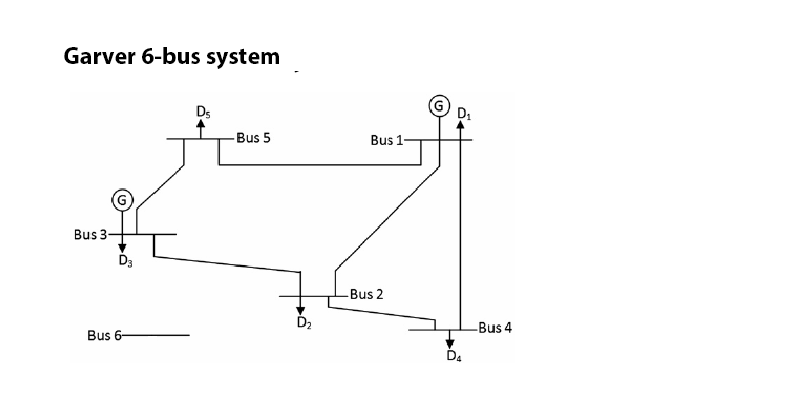

In [33]:
load("Garver.png")

In [34]:
# Line data for Garver 6 bus example
Line_ID = 1:15; 
Corridor = ["1-2","1-3","1-4","1-5","1-6","2-3","2-4","2-5","2-6","3-4","3-5","3-6","4-5","4-6","5-6"]
Resistance = [0.10,0.09,0.15,0.05,0.17,0.05,0.10,0.08,0.08,0.15,0.05,0.12,0.16,0.08,0.15]
Reactance = [0.40,0.38,0.60,0.20,0.68,0.20,0.40,0.31,0.30,0.59,0.20,0.48,0.63,0.30,0.61]
Line_cost = [40.,38,60,20,68,20,40,31,30,59,20,48,63,30,61]
Capacity_MW = [100,100,80,100,70,100,100,100,100,82,100,100,75,100,78]

Garver_line = DataFrame(Line_ID = Line_ID, Corridor = Corridor, Resistance = Resistance, 
    Reactance = Reactance, Investment_Cost = round(Line_cost), Capacity_MW = Capacity_MW)

,Line_ID,Corridor,Resistance,Reactance,Investment_Cost,Capacity_MW
1,1,1-2,0.1,0.4,40.0,100
2,2,1-3,0.09,0.38,38.0,100
3,3,1-4,0.15,0.6,60.0,80
4,4,1-5,0.05,0.2,20.0,100
5,5,1-6,0.17,0.68,68.0,70
6,6,2-3,0.05,0.2,20.0,100
7,7,2-4,0.1,0.4,40.0,100
8,8,2-5,0.08,0.31,31.0,100
9,9,2-6,0.08,0.3,30.0,100
10,10,3-4,0.15,0.59,59.0,82


In [35]:
# Existing Lines Garver
Ex_ID = [1,3,4,6,7,11]
Ex_lines = DataFrame(Line_ID = Line_ID[Ex_ID], Corridor = Corridor[Ex_ID], 
    Resistance = Resistance[Ex_ID], Reactance = Reactance[Ex_ID], Capacity_MW = Capacity_MW[Ex_ID])

,Line_ID,Corridor,Resistance,Reactance,Capacity_MW
1,1,1-2,0.1,0.4,100
2,3,1-4,0.15,0.6,80
3,4,1-5,0.05,0.2,100
4,6,2-3,0.05,0.2,100
5,7,2-4,0.1,0.4,100
6,11,3-5,0.05,0.2,100


In [36]:
# Bus data for Garver 6 bus example
Bus_ID = 1:6; 
PG_max = [150.,0,360,0,0,600]
LMP_G = [10.,0,20,0,0,30]
PD = [80,240,40,160,240,0]

Garver_bus = DataFrame(Bus_ID = Bus_ID, PG_max_MW = PG_max, LMP_G = LMP_G, PD_MW = PD)

,Bus_ID,PG_max_MW,LMP_G,PD_MW
1,1,150.0,10.0,80
2,2,0.0,0.0,240
3,3,360.0,20.0,40
4,4,0.0,0.0,160
5,5,0.0,0.0,240
6,6,600.0,30.0,0


## DC Model Without Losses

- I will start by solving the following DC Model without losses for Garver's 6-bus system:

### Algorithm (DC Model without Losses)

#### Objective: minimize { σ ∑λⱼᴳPⱼᴳ + Kₛₜₖwₛₜₖ } 

σ - weighting factor to make investment and operational costs comparable

λⱼᴳ - locational marginal prices

Kₛₜₖ - Investment cost of constructing line in corridor (s,t)

wₛₜₖ - Binary variable that equals 1 if line k from (s,t) corridor is built and equals 0 otherwise

#### Constraints


- Pₛᴳ - ∑ Pₛₜₖ = Pₛᴰ for every bus s


- -wₛₜₖPₛₜₖᵐᵃˣ <= Pₛₜₖ <= wₛₜₖPₛₜₖᵐᵃˣ : for every line


- 0 <= Pⱼᴳ <= Pⱼᴳᵐᵃˣ : for every every unit j


- wₛₜₖ = 1 : for every existing line that is not prospective
    
    
- wₛₜₖ ϵ {0,1} : for every line



In [37]:
# line data
C1 = [1,1,1,1,1,2,2,2,2,3,3,3,4,4,5]
C2 = [2,3,4,5,6,3,4,5,6,4,5,6,5,6,6]

# resized line data vectors (45-long vectors)
Line_ID_jump = 1:45
Corridor_jump = [Corridor;Corridor;Corridor]
lcost_jump = [Line_cost;Line_cost;Line_cost]
Capacity_MW_jump = [Capacity_MW;Capacity_MW;Capacity_MW]
C1_jump = [C1;C1;C1]
C2_jump = [C2;C2;C2]

# NPV factor for 20 years with 10% discount rate to make fixed and operating costs compareable
df = 0.0
for i = 1:20
    df += 1/(1.1)^i
end
fy = 1/df

# bus data
generators = [1,3,6]
loads = [2,4,5];

In [38]:
# sets of bus and neighboring line IDs
bus_1_c1 = Int64[]; bus_2_c1 = Int64[]; bus_3_c1 = Int64[]; bus_4_c1 = Int64[]; bus_5_c1 = Int64[]; bus_6_c1 = Int64[]
bus_1_c2 = Int64[]; bus_2_c2 = Int64[]; bus_3_c2 = Int64[]; bus_4_c2 = Int64[]; bus_5_c2 = Int64[]; bus_6_c2 = Int64[]

for i = 1:45
    if C1_jump[i] == 1
        bus_1_c1 = push!(bus_1_c1,i)
    elseif C1_jump[i] == 2
        bus_2_c1 = push!(bus_2_c1,i)
    elseif C1_jump[i] == 3
        bus_3_c1 = push!(bus_3_c1,i)
    elseif C1_jump[i] == 4
        bus_4_c1 = push!(bus_4_c1,i)       
    elseif C1_jump[i] == 5
        bus_5_c1 = push!(bus_5_c1,i)
     elseif C1_jump[i] == 6
        bus_6_c1 = push!(bus_6_c1,i)
    end
end   
   
for i = 1:45
    if C2_jump[i] == 1
        bus_1_c2 = push!(bus_1_c2,i)
    elseif C2_jump[i] == 2
        bus_2_c2 = push!(bus_2_c2,i)
    elseif C2_jump[i] == 3
        bus_3_c2 = push!(bus_3_c2,i)
    elseif C2_jump[i] == 4
        bus_4_c2 = push!(bus_4_c2,i)     
    elseif C2_jump[i] == 5
        bus_5_c2 = push!(bus_5_c2,i)
     elseif C2_jump[i] == 6
        bus_6_c2 = push!(bus_6_c2,i)
    end
end  

In [39]:
# Set of lines going from bus s
bus_mat_c1 = [bus_1_c1,bus_2_c1,bus_3_c1,bus_4_c1,bus_5_c1,bus_6_c1]

6-element Array{Array{Int64,1},1}:
 [1,2,3,4,5,16,17,18,19,20,31,32,33,34,35]
 [6,7,8,9,21,22,23,24,36,37,38,39]        
 [10,11,12,25,26,27,40,41,42]             
 [13,14,28,29,43,44]                      
 [15,30,45]                               
 Int64[]                                  

In [40]:
# Set of lines going into bus s
bus_mat_c2 = [bus_1_c2,bus_2_c2,bus_3_c2,bus_4_c2,bus_5_c2,bus_6_c2]

6-element Array{Array{Int64,1},1}:
 Int64[]                                     
 [1,16,31]                                   
 [2,6,17,21,32,36]                           
 [3,7,10,18,22,25,33,37,40]                  
 [4,8,11,13,19,23,26,28,34,38,41,43]         
 [5,9,12,14,15,20,24,27,29,30,35,39,42,44,45]

In [41]:
# activate a mixed integer-linear solver

function DC_no_loss()

m = Model(solver = GLPKSolverMIP())

@variable(m, w[1:45], Bin) # 45 variables because each line can be built up to 3 times
@variable(m, pst[1:45]) # lineflow as variables

# Set a constraint for exisiting lines
@constraint(m, exconstr[i=1:6], w[Ex_ID[i]] == 1)

# Calculate an expression for the power flows through each bus
@expression(m, pf[i=1:6], sum(pst[j] for j in bus_mat_c1[i])-sum(pst[j] for j in bus_mat_c2[i]))

# Calculate an expression for the power generated
@expression(m, pg[i=1:6], PD[i]+pf[i])
                    
# Define the minimization objective
@expression(m, gen_costs, sum(pg[i]*LMP_G[i] for i = 1:6))
@expression(m, line_costs, sum(w[i]*lcost_jump[i] for i = 1:45))
            
@objective(m, Min, line_costs + gen_costs*(fy*8760/10^6)) 

# Generator flow constraints
@constraint(m, gen[i=1:6], 0 <= pg[i] <= PG_max[i])
                                    
# Line flow constraints
@expression(m, min_flow[i=1:45], -w[i]*Capacity_MW_jump[i])
@expression(m, max_flow[i=1:45], w[i]*Capacity_MW_jump[i]) 
                                    
@constraint(m, min_flow_cstr[i=1:45], pst[i] >= min_flow[i])
@constraint(m, max_flow_cstr[i=1:45], pst[i] <= max_flow[i])
                                    
# Load constraints
@constraint(m, load_balance[i = 1:6] , pg[i] - pf[i] == PD[i])
                                    
solve(m)

W_jump_nl = getvalue(w)
pst_jump_nl = getvalue(pst)
pg_jump_nl = getvalue(pg)
line_costs_jump_nl = getvalue(line_costs)
                                            
obj_nl = getobjectivevalue(m)  

return W_jump_nl, pst_jump_nl, pg_jump_nl, line_costs_jump_nl, obj_nl
                                                
end                                  

DC_no_loss (generic function with 1 method)

In [42]:
(W_jump_nl, pst_jump_nl, pg_jump_nl, line_costs_jump_nl, obj_nl) = DC_no_loss();

## Results

In [43]:
nl_lines = find(W_jump_nl[1:end])
nl_new_lines = setdiff(nl_lines,Ex_ID)
n_lines_DC_wo_loss = size(nl_new_lines)[1]
println("the number of new lines required is $n_lines_DC_wo_loss")

the number of new lines required is 4


In [44]:
time_nl = @elapsed DC_no_loss();
@time DC_no_loss();

  0.042622 seconds (5.64 k allocations: 404.297 KB)


### Additional lines built

In [45]:
Ex_lines = DataFrame(Line_ID = Line_ID_jump[nl_new_lines], Corridor = Corridor_jump[nl_new_lines], 
    Capacity_MW = Capacity_MW_jump[nl_new_lines], Investment_Cost = lcost_jump[nl_new_lines])

,Line_ID,Corridor,Capacity_MW,Investment_Cost
1,14,4-6,100,30.0
2,29,4-6,100,30.0
3,41,3-5,100,20.0
4,44,4-6,100,30.0


### Line Flows

In [46]:
DataFrame(Line_ID = Line_ID_jump[nl_lines], Coridor = Corridor_jump[nl_lines], Line_flow_MW = pst_jump_nl[nl_lines])

,Line_ID,Coridor,Line_flow_MW
1,1,1-2,40.0
2,3,1-4,-10.0
3,4,1-5,40.0
4,6,2-3,-100.0
5,7,2-4,-100.0
6,11,3-5,100.0
7,14,4-6,-70.0
8,29,4-6,-100.0
9,41,3-5,100.0
10,44,4-6,-100.0


### Power summary for each bus

In [47]:
DataFrame(Bus_ID = Bus_ID, PG_MW = pg_jump_nl, LMP_G = LMP_G, PD_MW = PD)

,Bus_ID,PG_MW,LMP_G,PD_MW
1,1,150.0,10.0,80
2,2,0.0,0.0,240
3,3,340.0,20.0,40
4,4,0.0,0.0,160
5,5,0.0,0.0,240
6,6,270.0,30.0,0


### Investment Costs

In [48]:
inv_nl = line_costs_jump_nl - sum(lcost_jump[Ex_ID])
gen_nl = obj_nl-inv_nl
println("The total investment cost of new lines is $inv_nl M dollars")

The total investment cost of new lines is 110.0 M dollars


### Algorithm (Linearized LP Model with Losses)

#### Objective: minimize { σ ∑λⱼᴳPⱼᴳ + Kₛₜₖwₛₜₖ } 

σ - weighting factor to make investment and operational costs comparable

λⱼᴳ - locational marginal prices

Kₛₜₖ - Investment cost of constructing line in corridor (s,t)

wₛₜₖ - Binary variable that equals 1 if line k from (s,t) corridor is built and equals 0 otherwise

#### Constraints:

- ∑ Pⱼᴳ - ∑ [ fₛₜₖ + 1/2 qₛₜₖ ] = Pₛᴰ : for every bus s


- -wₛₜₖPₛₜₖᵐᵃˣ <= fₛₜₖ <= wₛₜₖPₛₜₖᵐᵃˣ : for every line


- -(1 - wₛₜₖ ) Mₛₜ <= fₛₜₖ/bₛₜₖ + (δₛₜ⁺ - δₛₜ⁻) <= ( 1 - wₛₜₖ ) Mₛₜ : for every line


- 0 <= qₛₜₖ <= wₛₜₖPₛₜₖᵐᵃˣ : for every line


- 0 <= -qₛₜₖ/gₛₜₖ + ∑ αₛₜ(x) δₛₜ(x) <= (1 - wₛₜₖ ) Mₛₜ² : for every line


- δₛₜ⁺ + δₛₜ⁻ = ∑ δₛₜ(x) : for every line


- δₛ - δₜ = δₛₜ⁺ + δₛₜ⁻ : for every line


- fₛₜₖ + 1/2 qₛₜₖ <= Pₛₜₖᵐᵃˣ : for every line


- -fₛₜₖ + 1/2 qₛₜₖ <= Pₛₜₖᵐᵃˣ : for every line


- 0 <= Pⱼᴳ <= Pⱼᴳᵐᵃˣ : for every every unit j


- wₛₜₖ = 1 : for every existing line that is not prospective
    
    
- wₛₜₖ ϵ {0,1} : for every line


- δₛ = 0 : reference bus


- δₛₜ⁺ >= 0 ; δₛₜ⁻ >= 0 : for every line


- δₛₜ(x) >= 0 : for every line and for every piecewise segment


- δₛₜ(x) <= ∆δₛₜ + (1-wₛₜₖ) Mₛₜ : for every line and for every piecewise segment

    
bₛₜₖ - Susceptance of line k in corridor (s,t)

gₛₜₖ - conductance of line k in corridor (s,t)

qₛₜₖ - Power losses in line k of corridor (s,t) in scenario c

fₛₜₖ - Lossless power flow in line k of corridor (s,t) in scenario c

δₛ - Voltage angle at bus s in scenario c

δₛₜ(x) - Variable used in the linearization of the power losses in corridor (s,t); it represents the the xth angle block relative to this corridor

αₛₜ(x) - Slope of the the xth block of the voltage angle for the corridor (s,t)

∆δₛₜ - Upper bound of the angle blocks of corridor (s,t)

Mₛₜ - Large enough positive constant

δₛₜ⁺ - Variable used in the linearization of the power losses in corridor (s,t)

δₛₜ⁻ - Variable used in the linearization of the power losses in corridor (s,t)

In [49]:
# line data susceptance and conductance
b = -Reactance./(Reactance.^2+Resistance.^2)
g = Resistance./(Reactance.^2+Resistance.^2)

# resized line data vectors (45-long vectors)
b_jump = 100*[b;b;b]
g_jump = 100*[g;g;g]

# buses
delta_lim = 20*π/180

# other
Mₛₜ = 10^3 # Positive constant needed for relaxation
L = 4 # Number of blocks of the piecewise linearization of power losses

αₛₜ = zeros(L); #Slope of the lth block of the voltage angle for the corridor (s,t)
for i = 1:L
    αₛₜ[i] = ((i*delta_lim)^2-(i*delta_lim-delta_lim)^2)/delta_lim
end

In [50]:
# activate mixed integer-linear solver
function MILP()

n = Model(solver = GLPKSolverMIP(msg_lev=GLPK.MSG_OFF))

@variable(n, δₛ[1:6])
@variable(n, δₛₜ⁺[1:45] >= 0) # support variable
@variable(n, δₛₜ⁻[1:45] >= 0) # support variable
@variable(n, δₗ[1:45,1:L] >= 0) # support variable
@variable(n, w[1:45], Bin) # 45 variables because each line can be built up to 3 times
@variable(n, fst[1:45])
@variable(n, qst[1:45])
@variable(n, pg[1:6])

# Set a constraint for exisiting lines
@constraint(n, exconstr[i=1:6], w[Ex_ID[i]] == 1)

# Set constraint for reference bus
@constraint(n, refbus, δₛ[1] == 1)

# Calculate an expression for the power flows through each bus
@expression(n, f[i=1:6],sum(fst[j]+qst[j] for j in bus_mat_c1[i])-sum(fst[j] for j in bus_mat_c2[i])) 

# Load constraints
@constraint(n, load_balance_loss[i = 1:6] , pg[i] - f[i] == PD[i])

# Line flow constraints
@expression(n, min_flow_loss[i=1:45], -w[i]*Capacity_MW_jump[i])
@expression(n, max_flow_loss[i=1:45], w[i]*Capacity_MW_jump[i]) 
                    
@constraint(n, min_flow_cstr_loss[i=1:45], fst[i] >= min_flow_loss[i])
@constraint(n, max_flow_cstr_loss[i=1:45], fst[i] <= max_flow_loss[i])

# Elimination of non-linearity constraints
@constraint(n, min_non_l[i=1:45], fst[i]/b_jump[i]+(δₛₜ⁺[i]-δₛₜ⁻[i]) >= -(1-w[i])*Mₛₜ)
@constraint(n, max_non_l[i=1:45], fst[i]/b_jump[i]+(δₛₜ⁺[i]-δₛₜ⁻[i]) <= (1-w[i])*Mₛₜ)

# Line loss constraints
@constraint(n, min_loss[i=1:45], qst[i] >= 0)
@constraint(n, max_loss[i=1:45], qst[i] <= w[i]*Capacity_MW_jump[i])
 
# Linear loss constraints
@expression(n, linear_loss[i=1:45], sum(αₛₜ[j]*δₗ[i,j] for j = 1:L))
@constraint(n, min_loss_lin[i=1:45], -qst[i]/g_jump[i] + linear_loss[i] >=0)                    
@constraint(n, max_loss_lin[i=1:45], -qst[i]/g_jump[i] + linear_loss[i] <= (1-w[i])*Mₛₜ^2)

# Angle constraints
@constraint(n, sum_angle[i=1:45], δₛₜ⁺[i]+δₛₜ⁻[i] == sum(δₗ[i,j] for j = 1:L))
@constraint(n, diff_angle[i=1:45], δₛ[C1_jump[i]]-δₛ[C2_jump[i]] == δₛₜ⁺[i]-δₛₜ⁻[i])

# Power balance constraints
@constraint(n, pos_bal[i=1:45], fst[i] + 0.5*qst[i] <= w[i]*Capacity_MW_jump[i])
@constraint(n, neg_bal[i=1:45],-fst[i] + 0.5*qst[i] <= w[i]*Capacity_MW_jump[i])
                                
# Generator flow constraints
@constraint(n, gen[i=1:6], 0 <= pg[i] <= PG_max[i])
                                
# angle linearization constraint
@constraint(n, angle_lin[i=1:45,j=1:L], δₗ[i,j] <= delta_lim + (1-w[i])*Mₛₜ)
                                
# Define the minimization objective
@expression(n, gen_costs_loss, sum(pg[i]*LMP_G[i] for i = 1:6))
@expression(n, line_costs_loss, sum(w[i]*lcost_jump[i] for i = 1:45))
            
@objective(n, Min, line_costs_loss + gen_costs_loss*(fy*8760/10^6))
                                    
solve(n)

W_jump_lp = getvalue(w)
pg_jump_lp = getvalue(pg)
qst_jump_lp = getvalue(qst)
fst_jump_lp = getvalue(fst)
line_costs_jump_lp = getvalue(line_costs_loss)
                                                        
obj_lp = getobjectivevalue(n)                                                                          
 
return W_jump_lp, pg_jump_lp, qst_jump_lp, qst_jump_lp, fst_jump_lp, line_costs_jump_lp, obj_lp
                                                                        
end                                                                
                                                              

MILP (generic function with 1 method)

In [51]:
(W_jump_lp, pg_jump_lp, qst_jump_lp, qst_jump_lp, fst_jump_lp, line_costs_jump_lp, obj_lp) = MILP();

## Results

In [52]:
lp_lines = find(W_jump_lp[1:end])
lp_new_lines = setdiff(lp_lines,Ex_ID)
n_lines_DC_w_loss = size(lp_new_lines)[1]
println("the number of new lines required is $n_lines_DC_w_loss")

the number of new lines required is 5


In [53]:
time_lp = @elapsed MILP();
@time MILP();

  0.648968 seconds (18.89 k allocations: 1.390 MB)


### Additional lines built

In [54]:
Ex_lines = DataFrame(Line_ID = Line_ID_jump[lp_new_lines], Corridor = Corridor_jump[lp_new_lines], 
    Capacity_MW = Capacity_MW_jump[lp_new_lines], Investment_Cost = lcost_jump[lp_new_lines])

,Line_ID,Corridor,Capacity_MW,Investment_Cost
1,9,2-6,100,30.0
2,24,2-6,100,30.0
3,29,4-6,100,30.0
4,41,3-5,100,20.0
5,44,4-6,100,30.0


### Line Flows

In [55]:
DataFrame(Line_ID = Line_ID_jump[lp_lines], Coridor = Corridor_jump[lp_lines], 
    Line_flow_MW = round(fst_jump_lp[lp_lines],3), Losses_MW = round(qst_jump_lp[lp_lines],3))

,Line_ID,Coridor,Line_flow_MW,Losses_MW
1,1,1-2,10.703,0.934
2,3,1-4,5.317,0.464
3,4,1-5,48.362,4.22
4,6,2-3,-68.863,6.009
5,7,2-4,-2.728,0.238
6,9,2-6,-90.391,8.414
7,11,3-5,95.819,8.362
8,24,2-6,-90.391,8.414
9,29,4-6,-86.783,8.078
10,41,3-5,95.819,8.362


### Power summary for each bus

In [56]:
DataFrame(Bus_ID = Bus_ID, PG_MW = round(pg_jump_lp,1), LMP_G = LMP_G, PD_MW = PD)

,Bus_ID,PG_MW,LMP_G,PD_MW
1,1,150.0,10.0,80
2,2,-0.0,0.0,240
3,3,317.2,20.0,40
4,4,-0.0,0.0,160
5,5,-0.0,0.0,240
6,6,354.3,30.0,0


### Investment Costs

In [57]:
inv_lp = line_costs_jump_lp - sum(lcost_jump[Ex_ID])
gen_lp = obj_lp-inv_lp
println("The total investment cost of new lines is $inv_lp M dollars")

The total investment cost of new lines is 140.0 M dollars


## Summary of the Results (both models)

In [58]:
Results = DataFrame(Model = ["DC w/o Loss","MILP w/ Loss"],Lines_built = [Corridor_jump[nl_new_lines],
        Corridor_jump[lp_new_lines]],Investment_Musd = [inv_lp,inv_nl],Gen_costs_Musd = round([gen_lp,gen_nl],2),
            Total_costs_Musd = round([obj_nl, obj_lp],2), Losses_MW = round([0, sum(qst_jump_lp)],2),
                Time_seconds = [time_nl,time_lp])

,Model,Lines_built,Investment_Musd,Gen_costs_Musd,Total_costs_Musd,Losses_MW,Time_seconds
1,DC w/o Loss,"String[""4-6"",""4-6"",""3-5"",""4-6""]",140.0,219.01,326.87,0.0,0.040056447
2,MILP w/ Loss,"String[""2-6"",""2-6"",""4-6"",""3-5"",""4-6""]",110.0,216.87,359.01,61.57,0.650095484


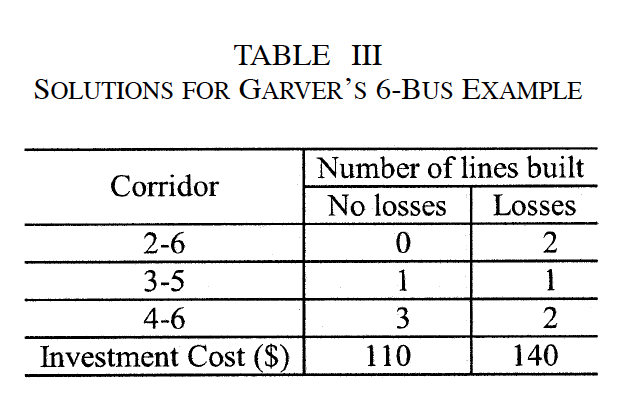

In [59]:
# Results from the paper
load("Results_paper.png")

## Findings

- We can see that I come up with the same as the author.


- We can also conclude, that without considering losses, we underestimate line investment and the problem becomes infeasible.


- We can also see that considering losses becomes computationally intensive, it takes 25 times more time to solve the model with losses. For larger systems, this may create concerns as computing time rises exponentially.


- One final thing to note is that the solution is very sensitive to:

    - large constant used for the relaxation
    - degree of the polynomial used to interpolate the losses